In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Import own code
from signal_data_class import SignalData
from plot_data import plot_inv_frac, plot_all_3d

sb.set()

SN1 = "../data/SN1_Chirp_300kHzTemplate_0p16SNR_280Start_Sig.npy"  # Nasty noise
SN2 = "../data/SN2_Chirp_300kHzTemplate_0p32SNR_280Start_Sig.npy"  # Nice noise
SX1 = "../data/SX1_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_99mV.npy"
SX2 = "../data/SX2_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_132mV.npy"
SX3 = "../data/SX3_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_264mV.npy"
XN1 = "../data/XN1_Chirp_300kHzTemplate_0p16SNR_280Start_Noise.npy"  # Nasty noise
XN2 = "../data/XN2_Chirp_300kHzTemplate_0p32SNR_280Start_Noise.npy"  # Nice noise


In [2]:
data = {}
# data["SN1"] = np.array(list( zip(*np.load(SN1)) ))
# data["SN2"] = np.array(list( zip(*np.load(SN2)) ))
data["SX1"] = np.array(list( zip(*np.load(SX1)) ))
# data["SX2"] = np.array(list( zip(*np.load(SX2)) ))
# data["SX3"] = np.array(list( zip(*np.load(SX3)) ))
data["XN1"] = np.array(list( zip(*np.load(XN1)) ))
data["XN2"] = np.array(list( zip(*np.load(XN2)) ))

df = pd.read_csv("../data/SX1+XN1.csv")
data["SX1+XN1"] = [df.t, df.signal]
df = pd.read_csv("../data/SX1+XN2.csv")
data["SX1+XN2"] = [df.t, df.signal]

SX1_truth_data_df = pd.read_csv("../data/SX1_truth_data.csv")
# SX1_truth_data = list(SX1_truth_data_df.truth_data)
SX1_truth_data = SX1_truth_data_df.truth_data


In [3]:
t1 = SignalData(data["SX1"], truth_data = SX1_truth_data,
                slice_start = 0, slice_end = 50000)

inv_frac_vals = np.arange(1, 6, 0.5)
delay_samples_vals = np.arange(50, 250, 25)

t1_all_test_params = t1.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        verbose = True,
                                       )

t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t1_pd.to_csv("t1_performance_data.csv.temp")


........
........
Wall time: 6 secs
CPU time: 4 secs


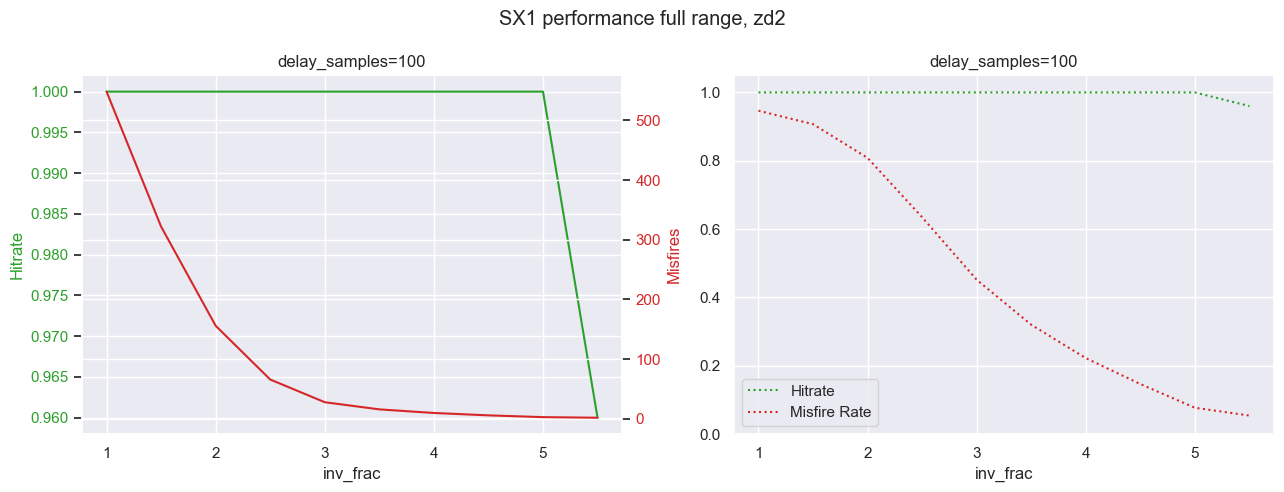

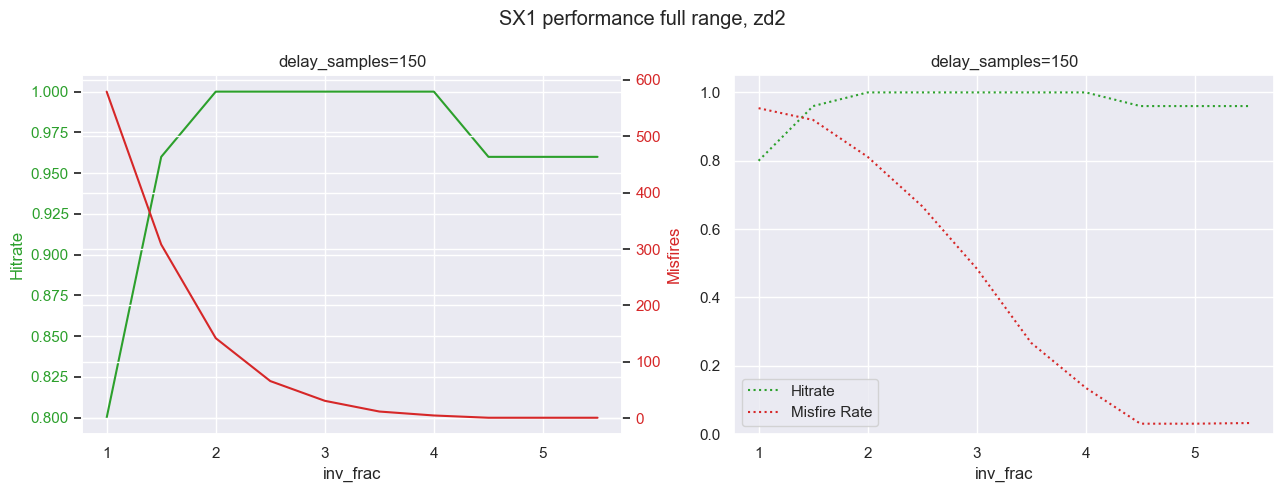

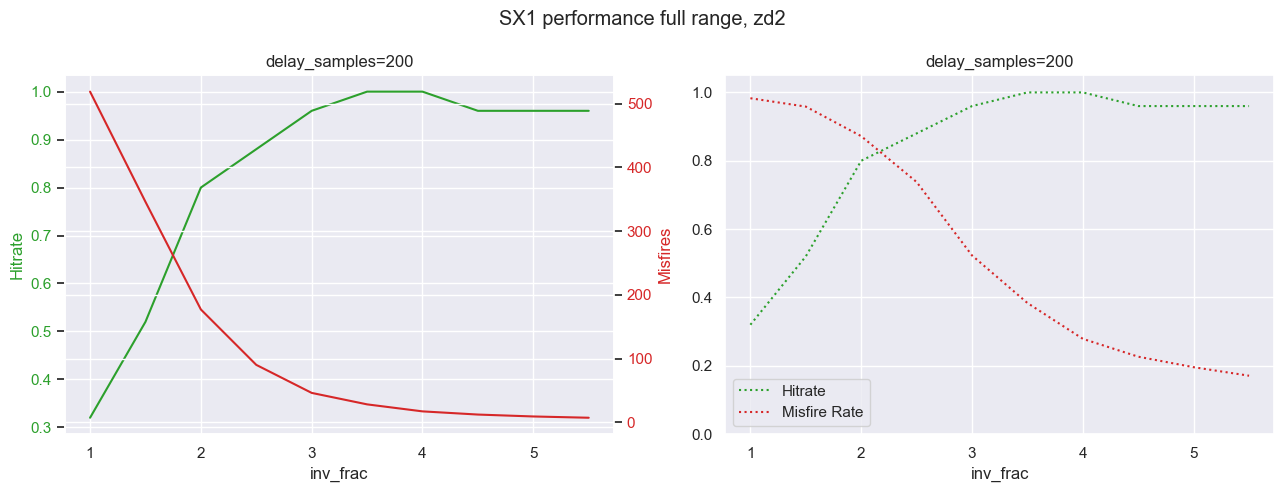

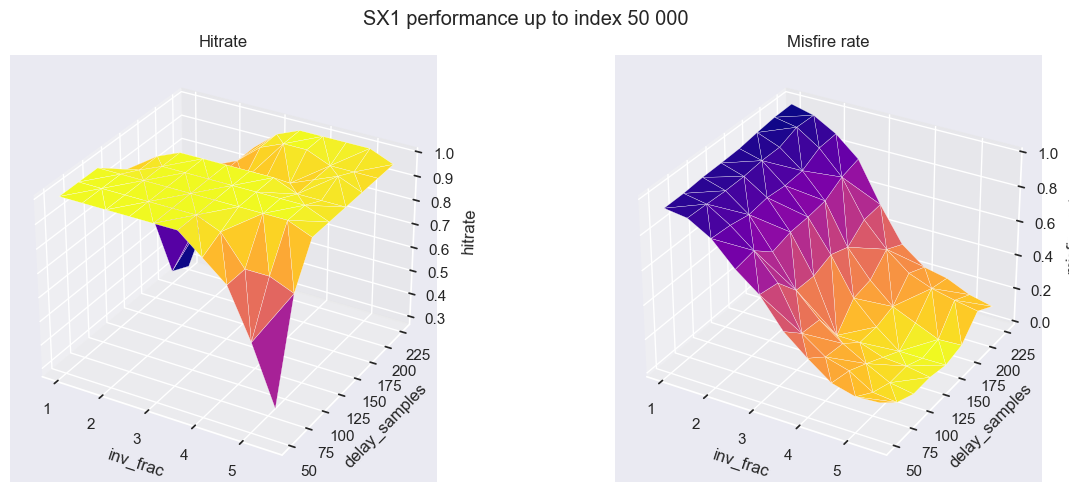

In [4]:
t1_pd_analyse = pd.read_csv("t1_performance_data.csv.temp")

plot_inv_frac(t1_pd_analyse, delay_samples=100, title="SX1 performance full range, zd2")
plot_inv_frac(t1_pd_analyse, delay_samples=150, title="SX1 performance full range, zd2")
plot_inv_frac(t1_pd_analyse, delay_samples=200, title="SX1 performance full range, zd2")
plot_all_3d(t1_pd_analyse, title="SX1 performance up to index 50 000")
print()


In [ ]:
t2 = SignalData(data["SX1"], truth_data = SX1_truth_data)

inv_frac_vals = np.arange(2, 7 + 0.25, 0.25)  # Add step size to endpoint to include endpoint
delay_samples_vals = np.arange(50, 350 + 15, 15)  # Add step size to endpoint to include endpoint

t2_all_test_params = t2.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        verbose = True,
                                       )

t2_pd = pd.DataFrame(t2_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t2_pd.to_csv("t2_performance_data.csv.temp")


.....................
..............

In [ ]:
t2_pd_analyse = pd.read_csv("t2_performance_data.csv.temp")

plot_inv_frac(t2_pd_analyse, delay_samples=95, title="SX1 performance full range, zd2")
plot_inv_frac(t2_pd_analyse, delay_samples=155, title="SX1 performance full range, zd2")
plot_inv_frac(t2_pd_analyse, delay_samples=200, title="SX1 performance full range, zd2")
plot_all_3d(t2_pd_analyse, title="SX1 performance full range, zd2, numba!")
print()


In [ ]:
t3 = SignalData(data["SX1+XN2"], truth_data = SX1_truth_data)

inv_frac_vals = np.arange(2, 7 + 0.25, 0.25)  # Add step size to endpoint to include endpoint
delay_samples_vals = np.arange(50, 350 + 15, 15)  # Add step size to endpoint to include endpoint

t3_all_test_params = t3.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        verbose = True,
                                       )

t3_pd = pd.DataFrame(t3_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t3_pd.to_csv("t3_performance_data.csv.temp")


In [ ]:
t3_pd_analyse = pd.read_csv("t3_performance_data.csv.temp")
plot_all_3d(t3_pd_analyse, title="SX1+XN2 with SX1 truth data performance, full range, zd2")
print()


In [ ]:
t4 = SignalData(data["SX1+XN1"], truth_data = SX1_truth_data)

inv_frac_vals = np.arange(2, 7 + 0.25, 0.25)  # Add step size to endpoint to include endpoint
delay_samples_vals = np.arange(50, 350 + 15, 15)  # Add step size to endpoint to include endpoint

t4_all_test_params = t4.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        verbose = True,
                                       )

t4_pd = pd.DataFrame(t4_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t4_pd.to_csv("t4_performance_data.csv.temp")


In [ ]:
t4_pd_analyse = pd.read_csv("t4_performance_data.csv.temp")
plot_all_3d(t4_pd_analyse, title="SX1+XN1 with SX1 truth data performance, full range, zd2")
print()


In [ ]:
t5 = SignalData(data["SX1+XN2"], truth_data = SX1_truth_data)

t5_inv_frac_vals = np.arange(0, 10 + 1, 1)  # Add step size to endpoint to include endpoint
t5_delay_samples_vals = np.arange(50, 350 + 5, 5)  # Add step size to endpoint to include endpoint

t5_all_test_params = t5.get_performance(inv_frac_vals = t5_inv_frac_vals,
                                        delay_samples_vals = t5_delay_samples_vals,
                                        verbose = True,
                                       )

t5_pd = pd.DataFrame(t5_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t5_pd.to_csv("t5_performance_data.csv.temp")


In [ ]:
t5_pd_analyse = pd.read_csv("t5_performance_data.csv.temp")
plot_all_3d(t5_pd_analyse, title="SX1+XN2 with SX1 truth data performance, full range, zd2")
print()


In [ ]:
t6 = SignalData(data["SX1+XN1"], truth_data = SX1_truth_data)

t6_inv_frac_vals = np.arange(0, 10 + 1, 1)  # Add step size to endpoint to include endpoint
t6_delay_samples_vals = np.arange(50, 350 + 5, 5)  # Add step size to endpoint to include endpoint

t6_all_test_params = t6.get_performance(inv_frac_vals = t6_inv_frac_vals,
                                        delay_samples_vals = t6_delay_samples_vals,
                                        verbose = True,
                                       )

t6_pd = pd.DataFrame(t6_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t6_pd.to_csv("t6_performance_data.csv.temp")


In [ ]:
t6_pd_analyse = pd.read_csv("t6_performance_data.csv.temp")
plot_all_3d(t6_pd_analyse, title="SX1+XN1 with SX1 truth data performance, full range, zd2")
print()
